# Optimal Public Expenditure

This notebook calibrated the parameters in a simple matching model of the business cycle based on US data and computes the optimal level of public expenditure.

In [1]:
# %load setup.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick

## Calibration


In this section, we calibrate the parameters needed to calculate optimal stimulus with US data between 2001 and 2019. We  use the assumption that the economy, on average, is efficient. 

We fetch the data series from FRED. To do this, we use the `fredapi` package. 

In [2]:
from fredapi import Fred
# API key needs to be taken out when deployed
fred = Fred(api_key='30adf5295a539a48e57fe367896a60e9')

Our calibration period is between the start of 2001 and the end of 2019.

In [3]:
start_date = '2001-01-01'
end_date = '2019-12-31'

### Calibration of $s$

The parameter $s$ is the job separation rate. We calibrate it with the average separation rate in the US over the sample period. 

In [4]:
s_ts = fred.get_series('JTSTSR', frequency='q', observation_start=start_date, observation_end=end_date)/100

Here is what the US job separation rate looks like over our sample period.

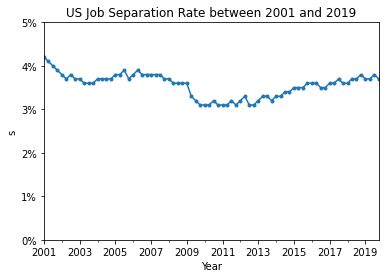

In [5]:
s_ax = s_ts.plot(title="US Job Separation Rate between 2001 and 2019", marker='.')
s_ax.set(xlabel='Year', ylabel='s', ylim=(0, 0.05))
s_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

We now calibrate $s$ and find that it is around $3.6\%$.

In [6]:
s = s_ts.mean()
s

0.03557894736842106

### Calibration of $\bar{u}$

We now calibrate $\bar{u}$, which is the steady-state unemployment rate. We set it to be the average US unemployment rate over our sample period.

In [7]:
u_ts = fred.get_series('UNRATE', frequency='q', observation_start=start_date, observation_end=end_date)/100

This is what unemployment rate in the US looks like over our sample period:

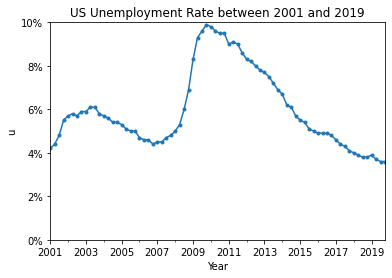

In [8]:
u_ax = u_ts.plot(title="US Unemployment Rate between 2001 and 2019", marker='.')
u_ax.set(xlabel='Year', ylabel='u', ylim=(0, 0.1))
u_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

Taking the average gives us the calibrated value of $\bar{u}$, which is around $6\%$.

In [9]:
u_bar = u_ts.mean()
u_bar

0.05974999999999999

### Calibration of $\bar{x}$

We now claibrate $\bar{x}$, which denotes steady-state labor market tightness. We calibrate it with the average US labor market tightness over our sample period.

Note that labor market tightness is defined as:

$$x(t) = \frac{v(t)}{k-Y(t)},$$

where $v$ denotes the vacancy level, $k$ the productive capacity of households, and $Y$ the output. Therefore, $k - Y(t)$ is simply the unemployment level, since we assume output to only come from services provided by households. 

In [10]:
v_ts = fred.get_series('JTSJOL', frequency='q', observation_start=start_date, observation_end=end_date)
ul_ts = fred.get_series('UNEMPLOY', frequency='q', observation_start=start_date, observation_end=end_date)
x_ts = v_ts/ul_ts

Here is what labor market tightness in the US looks like over our sample period.

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'x'), (0.0, 1.4)]

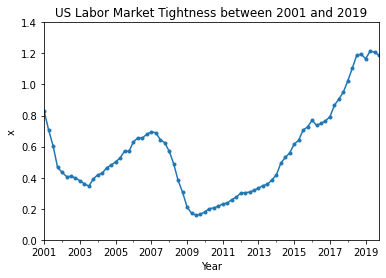

In [11]:
x_ax = x_ts.plot(title="US Labor Market Tightness between 2001 and 2019", marker='.')
x_ax.set(xlabel='Year', ylabel='x', ylim=(0, 1.4))

We now calibrate the steady-state labor market tightness $\bar{x}$ and find that it is around $0.56$.

In [12]:
x_bar = x_ts.mean()
x_bar

0.557752047505985

### Calibration of $\overline{G/C}$

$\overline{G/C}$ is the steady-state ratio between public and private employment. We calibrate it with the average value ratio between public and private employment in the US over our sample period. 

In [13]:
G_ts = fred.get_series('USGOVT', frequency='q', observation_start=start_date, observation_end=end_date)
C_ts = fred.get_series('USPRIV', frequency='q', observation_start=start_date, observation_end=end_date)
GC_ts = G_ts/C_ts

This is what the ratio between public and private employment in the US looks like over our sample period:

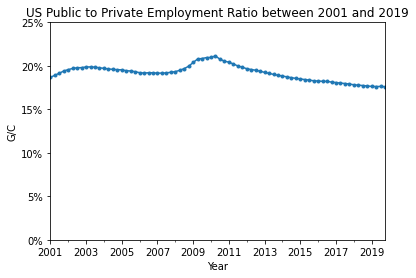

In [14]:
GC_ax = GC_ts.plot(title="US Public to Private Employment Ratio between 2001 and 2019", marker='.')
GC_ax.set(xlabel='Year', ylabel='G/C', ylim=(0, 0.25))
GC_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

We now calibrate the steady-state ratio $\overline{G/C}$, and find the average ratio between public and private employment to be around $19.2\%$.

In [15]:
GC_bar = GC_ts.mean()
GC_bar

0.19191729280673472

### Calibration of $\bar{M}$   [![Generic badge](https://img.shields.io/badge/MS19-p.%201324~1325-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

The parameter $M$ is the average unemployment multiplier. The unemployment multiplier is estimated by measuring the percentage-point change in the unemployment rate when public expenditure increases by $1\%$ of GDP. 

Monacelli et al. ([2010](http://dx.doi.org/10.1016/j.jmoneco.2010.05.009), pp. 533–536) estimate a structural vector autoregression (SVAR) on US data and find unemployment multipliers between $0.2$ and $0.6$. Ramey ([2013](http://doi.org/10.7208/chicago/9780226018584.003.0002), pp.40–42) estimates SVARs on US data with various identification schemes and sample periods and finds unemployment multipliers between $0.2$ and $0.5$, except in one specification where the multiplier is $1$.

The multiplier entering our formula could be larger if multipliers are larger when unemployment is higher, as suggested by recent research on state-dependent multipliers. For instance, estimating regime-switching SVARs on US data, Auerbach and Gorodnichenko ([2012](http://doi.org/10.1257/pol.4.2.1), table 1) find that while the output multiplier is $0.6$ in expansions and $1$ on average, it is as high as $2.5$ in recessions.

Thus, we use a range of unemployment multipliers with lower bound $0$, upper bound $2$, and median $1$.

In [16]:
M_bar_h, M_bar_l = 2, 0
M_bar = 1

### Calibration of $\epsilon$    [![Generic badge](https://img.shields.io/badge/MS19-p.%201324-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

The parameter $\epsilon$ is the elasticity of substitution between public and private consumption. Amano and Wirjanto ([1997](https://doi.org/10.1162/003465397557187), [1998](https://doi.org/10.1006/redy.1998.0021)) estimate the elasticity of substitution between public and private consumption to be 0.9 and 1.56. Here, we consider three values: $\epsilon = 0.5, \epsilon = 1$ and $\epsilon = 1.5.$ You can also play with the parameter values of $\epsilon$ below.

In [17]:
epsilon_h, epsilon_l = 1.5, 0.5
epsilon = 1

### Calibration of $\eta$    [![Generic badge](https://img.shields.io/badge/LMS18a-p.%20D7-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/5.html) 

The parameter $\eta$ is the matching elasticity, which is the elasticity of the matching function with respect to unemployment. A vast literature has attempted to estimate $\eta$. In their survey, Petrongolo
and Pissarides ([2001](https://doi.org/10.1257/jel.39.2.390), p. 424) conclude that the estimates of $\eta$ fall between 0.5 and 0.7. Here, we will set $\eta$ to be $0.6$, with an upper bound of $0.7$ and a lower bound of $0.5$.

Check the badge above for reference to a more detailed discussion. 

In [18]:
eta_h, eta_l = 0.7, 0.5
eta = 0.6

 ### Calibration of $\omega$   [![Generic badge](https://img.shields.io/badge/LMS18a-p.%20G28-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/5.html) 

 
The parameter $\omega$ denotes matching efficacy in the matching function. 

We calibrate $\omega$ by using the following equation: 

                $\omega = \bar{x}^{\eta - 1}\cdot \frac{s\cdot (1-\bar{u})}{\bar{u}\cdot e}, $            [![Generic badge](https://img.shields.io/badge/MS19-Eq%203-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  
     
where $e$ is the average job-search effort, which is normalized to $1$. We find that $\omega$ is roughly $0.71$.

In [19]:
omega_func = lambda eta:x_bar**(eta - 1)*s*(1 - u_bar)/u_bar
omega = omega_func(eta)
omega

0.7071671173494025

### Calibration of $\rho$

To calibrate $\rho$, we use the following relationship between the recruiter-producer ratio ($\tau$) and labor market tightness ($x$):

                $\tau(x) = \frac{\rho s}{q(x) - \rho s}, $              [![Generic badge](https://img.shields.io/badge/MS19-Eq%203-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  
                
where

                $q(x(t)) = \frac{h(t)}{v(t)}=\omega x(t)^{-\eta}.$         [![Generic badge](https://img.shields.io/badge/MS19-p.%201305-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  
                
This gives us that:

                $\rho = \frac{\omega x^{-\eta}\tau}{(1+\tau)s}.$
                
Note that since the relationship above holds for all $\tau$'s and $x$'s, we can find $\rho$ if we know what $\tau$ and $x$ are at the efficient level. 

When labor market tightness is efficient, we have:

                $(1-\eta)\bar{u}-\eta\bar{\tau} = 0, $            [![Generic badge](https://img.shields.io/badge/MS19-Eq%205-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

which can be re-arranged into:

                $\bar{\tau} = \frac{(1-\eta)\bar{u}}{\eta}.$ 

With this, we first calculate $\bar{\tau}$ and find that it is around $4\%$.

In [20]:
tau_bar_func = lambda eta:(1 - eta)*u_bar/eta
tau_bar = tau_bar_func(eta)
tau_bar

0.03983333333333333

We now calibrate $\rho$, which we find to be around $1.08$:

In [21]:
rho_func = lambda eta:omega_func(eta)*x_bar**(-1*eta)*tau_bar_func(eta)/((1 + tau_bar_func(eta))*s)
rho = rho_func(eta)
rho

1.080804575426955

### Calibration of $\tau$

As mentioned earlier, $\tau$ is the recruiter-producer ratio. Recall that

                $\tau(x) = \frac{\rho s}{q(x) - \rho s}, $              [![Generic badge](https://img.shields.io/badge/MS19-Eq%203-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html) 
                
where

                $q(x(t)) = \frac{h(t)}{v(t)}=\omega x(t)^{-\eta}.$         [![Generic badge](https://img.shields.io/badge/MS19-p.%201305-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

We now compute the time series for $\tau$ over our sample period.
           

In [22]:
q = lambda x, eta:omega_func(eta)*x**(-eta)
tau_ts_func = lambda eta:rho_func(eta)*s / (q(x_ts, eta) - rho_func(eta)*s)
tau_ts = tau_ts_func(eta)

This is what $\tau$ looks like over our sample period with different values of $\eta$ :

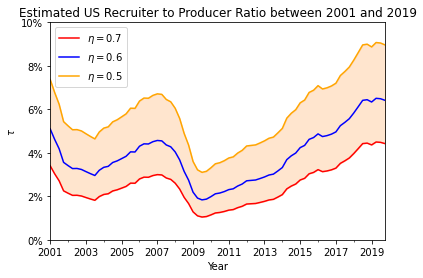

In [23]:
tau_h_ts, tau_l_ts = tau_ts_func(eta_h), tau_ts_func(eta_l) 
tau_range = pd.DataFrame(data={f'$\eta = ${eta_h}':tau_h_ts, 
                               f'$\eta = ${eta}':tau_ts, 
                               f'$\eta = ${eta_l}':tau_l_ts})
tau_range_ax = tau_range.plot(title=r"Estimated US Recruiter to Producer Ratio between 2001 and 2019", 
                              color=['red', 'blue', 'orange'])
tau_range_ax.set(xlabel='Year', ylabel=r'$\tau$', ylim=(0, 0.1))
tau_range_ax.fill_between(tau_range.index, tau_range[f'$\eta = ${eta_l}'], tau_range[f'$\eta = ${eta_h}'], 
                          alpha=0.2, color='tab:orange')
tau_range_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

When calculating the theoretical unemployment multiplier, we take $\tau$ to be its long-run average, which is around $3.9\%$.

In [24]:
tau_func = lambda eta:tau_ts_func(eta).mean()
tau = tau_func(eta)
tau

0.03873194401199106

### Calibration of $m$

$m$ is the theoretical unemployment multiplier, which measures the response of unemployment to changes in public consumption. $m$ is calibrated by using the following equation:

                $ m = \frac{(1-u)\cdot M}{1- \frac{G}{Y}\cdot \frac{\eta}{1-\eta}\cdot \frac{\tau}{u}\cdot M},$          [![Generic badge](https://img.shields.io/badge/MS19-Eq%2026-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)
                
where $G/Y$ follows the identity $G/Y = (G/C)/(1+G/C)$. Here, we will use the long-run average $\bar{u}, \overline{G/C}$ to calculate $m$. 

In [25]:
# Identity for conversion between G/Y and G/C
GY_func = lambda GC:GC/(1 + GC)
GY_bar = GY_func(GC_bar)
m_func = lambda M, eta:(1 - u_bar)*M/(1 - GY_bar*(eta)/(1 - eta)*tau_func(eta)*u_bar*M)
m = m_func(M_bar, eta)
m

0.9407758387748196

As shown above, $m$ is roughly equal to $M$. We also compute $m$ for different $M$'s and $\eta$'s:

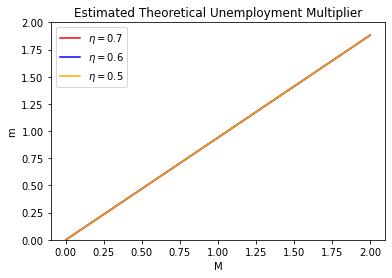

In [26]:
M_vals = np.linspace(start=M_bar_l, stop=M_bar_h, num=101)
m_vals, m_vals_h, m_vals_l = m_func(M_vals, eta), m_func(M_vals, eta_h), m_func(M_vals, eta_l)
m_range = pd.DataFrame(data={f'$\eta = ${eta_h}':m_vals_h, f'$\eta = ${eta}':m_vals,f'$\eta = ${eta_l}':m_vals_l},
                       index=M_vals)
m_range_ax = m_range.plot(title=r"Estimated Theoretical Unemployment Multiplier", color=['red', 'blue', 'orange'])
m_range_ax.set(xlabel='M', ylabel='m', ylim=(0, 2))
m_range_ax.fill_between(m_range.index, m_range[f'$\eta = ${eta_l}'], m_range[f'$\eta = ${eta_h}'], alpha=0.2, color='tab:orange')

As we can see, the choice of $\eta$ within our specified range makes very little difference. 

### Calibration of $z_0$ and $z_1$

We now calibrate $z_0$ and $z_1$. $z_0$ and $z_1$ can be calculated by using the following equations:

                $z_0 = \frac{1}{(1-\eta)(1-\bar{u})^2},$         [![Generic badge](https://img.shields.io/badge/MS19-p.%201315-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

and 


                $z_1 = \frac{\overline{g/y}\cdot \overline{c/y}}{\bar{u}}.$           [![Generic badge](https://img.shields.io/badge/MS19-p.%201316-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

We estimate $z_0$ to be about 2.83 and $z_1$ to be around $2.26$.

In [27]:
z0_func = lambda eta:1/((1 - eta)*(1 - u_bar)**2)
z0 = z0_func(eta)
z0

2.827830175507158

In [28]:
z1 = GY_bar*(1 - GY_bar)/u_bar
z1

2.2609135556386306

## Calculating Optimal Stimulus

We calculate optimal stimulus with the following equation:

                $\frac{g/c - (g/c)^*}{(g/c)^*} \approx \frac{z_0 \epsilon m}{1 + z_1 z_0\epsilon m^2}\cdot \frac{u_0 - \bar{u}}{\bar{u}}.$          [![Generic badge](https://img.shields.io/badge/MS19-Eq%2023-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

In [29]:
# This function calculates the optimal government spending to private consumption ratio
GC_func = lambda M, eta, epsilon, u0:z0*epsilon*m_func(M, eta)/(1 + z1*z0*epsilon*m_func(M, eta)**2)*(u0-u_bar)/u_bar * GC_bar + GC_bar
# This functio ncomputes the optimal government spending as percentage of GDP. 
stim_func = lambda M, eta, epsilon, u0:GY_func(GC_func(M, eta, epsilon, u0)) - GY_bar

Setting $u_0 = 9\%$ and $\eta = 0.6$, let's look at what the optimal stimulus is for different $M$'s and $\epsilon$'s:

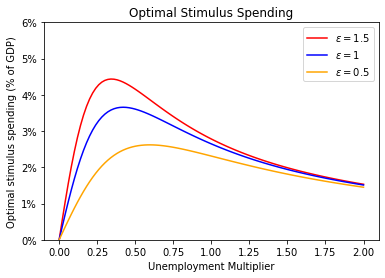

In [30]:
u0 = 0.09
stim_vals = stim_func(M_vals, eta, epsilon, u0)
stim_vals_h = stim_func(M_vals, eta, epsilon_h, u0)
stim_vals_l = stim_func(M_vals, eta, epsilon_l, u0)
stim_range = pd.DataFrame(index=M_vals,
                          data={f'$\epsilon = ${epsilon_h}':stim_vals_h, 
                                f'$\epsilon = ${epsilon}':stim_vals,
                                f'$\epsilon = ${epsilon_l}':stim_vals_l})
stim_range_ax = stim_range.plot(title=r"Optimal Stimulus Spending", color=['red', 'blue', 'orange'])
stim_range_ax.set(xlabel='Unemployment Multiplier', ylabel='Optimal stimulus spending (% of GDP)', ylim=(0, 0.06))
stim_range_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))